# TabNet Model Test

In this notebook, we'll test a training loop for the TabNet model 


In [1]:
import sys
sys.path.append('../src')

from models.lib.neural import *
from models.lib.data import *
from models.lib.train import *

import helper 
from helper import gene_intersection
from pytorch_tabnet.tab_network import TabNet

import torch.nn as nn 
import torch.optim as optim
import torch
from tqdm import tqdm
from torch.utils.data import Subset
from helper import seed_everything

seed_everything(42)

First, we'll define our train, val and test sets, then generate the associated DataLoaders and try training.

In [2]:
t = helper.INTERIM_DATA_AND_LABEL_FILES_LIST
datafiles, labelfiles = zip(*t.items())
datafiles = [f'../data/interim/{f}' for f in datafiles]
labelfiles = [f'../data/processed/labels/{f}' for f in labelfiles]
refgenes = gene_intersection()

datafiles, labelfiles

(['../data/interim/primary_bhaduri_T.csv',
  '../data/interim/allen_cortex_T.csv',
  '../data/interim/allen_m1_region_T.csv',
  '../data/interim/whole_brain_bhaduri_T.csv'],
 ['../data/processed/labels/primary_bhaduri_labels.csv',
  '../data/processed/labels/allen_cortex_labels.csv',
  '../data/processed/labels/allen_m1_region_labels.csv',
  '../data/processed/labels/whole_brain_bhaduri_labels.csv'])

In [3]:
train, val, test = generate_single_dataset(
    datafiles[0],
    labelfiles[0],
    'Type',
    skip=3,
)

In [4]:
print(len(train[0][0]))

19765


In [5]:
trainloader_map, _, _ = generate_single_dataloader(
    datafile=datafiles[0], 
    labelfile=labelfiles[0], 
    class_label='Type',
    skip=3,
    map_genes=True
)

trainloader_nomap, _, _ = generate_single_dataloader(
    datafile=datafiles[0], 
    labelfile=labelfiles[0], 
    class_label='Type',
    skip=3,
    map_genes=False
)

In [6]:
# for i, (X, y) in enumerate(tqdm(trainloader_map)):
#     if i == 200:
#         break

In [7]:
# for i, (X, y) in enumerate(tqdm(trainloader_nomap)):
#     if i == 200:
#         break
#     X = clean_sample(X, refgenes, train.features)
    

In [8]:
train_loader, val_loader, test_loader = generate_loaders(
    datafiles,
    labelfiles,
    'Type',
    num_workers=0,
    collocate=True,
)

In [9]:
# for X, y in train_loader:
#     print(type(train_loader))

In [10]:
len(refgenes)

16604

In [11]:
from models.lib.neural import TabNetGeneClassifier

model = TabNetGeneClassifier(
    input_dim=len(refgenes),
    output_dim=19
)

In [12]:
class SampleLoader(torch.utils.data.DataLoader):
    def __init__(self, refgenes, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.refgenes = refgenes
        self.currgenes = self.dataset.columns 
            
    def __iter__(self):
        for batch in super().__iter__():
            yield clean_sample(batch[0], self.refgenes, self.currgenes), batch[1]

In [22]:
test = SampleLoader(refgenes=refgenes, dataset=train, batch_size=11, num_workers=0)

In [23]:
# for X, y in test:
#     print(X)

## PyTorch-Lightning compatible TabNet architecture 

In [24]:
from models.lib.neural import GeneClassifier
from models.lib.neural import TabNetGeneClassifier

base_model = TabNetGeneClassifier(
    input_dim=len(refgenes),
    output_dim=19,
)

In [25]:
base_model.input_dim

16604

In [26]:
classifier = GeneClassifier(
    input_dim=base_model.input_dim,
    output_dim=base_model.output_dim,
    model=base_model
)

Model initialized. input_dim = 16604, output_dim = 19. Metrics are {'accuracy': <function accuracy at 0x7fcb92c3a3a0>, 'precision': <function precision at 0x7fcb92c4fee0>, 'recall': <function recall at 0x7fcb92c58040>} and weighted_metrics = False


In [27]:
sample = next(iter(test))[0]

classifier(sample)

tensor([[-1.1563e+00,  6.1421e-01, -5.7720e-02, -2.7440e-01, -5.6809e-01,
          1.8822e+00, -1.2550e-01,  1.3234e+00, -8.8077e-01, -1.2354e+00,
          8.6221e-01,  2.3478e-01, -8.8579e-01,  3.1630e-01, -4.0054e-01,
         -6.8034e-01,  4.7086e-01, -1.2678e-01,  2.0564e+00],
        [-7.0576e-01,  1.0763e+00,  5.6336e-01, -2.5588e-01,  4.9470e-01,
          1.3941e+00,  6.4407e-01,  7.1527e-01, -4.2848e-01, -7.9584e-01,
          2.2693e-01, -2.7052e-01, -1.6280e-01,  2.1129e-01, -4.2792e-01,
         -4.8361e-01,  1.1165e-01,  4.4577e-01,  9.5899e-02],
        [-6.3847e-01,  6.4753e-01,  1.7418e-01, -1.1129e-01,  6.8863e-01,
          1.5467e+00,  2.1099e-01,  2.5876e-01,  1.6656e-01, -5.7681e-01,
         -3.4057e-01, -1.0942e-01, -2.9596e-01, -9.8176e-01, -4.5809e-01,
         -5.2466e-01, -5.0747e-02, -1.1558e-01,  3.1388e-01],
        [-6.6908e-01,  1.7688e+00,  2.1910e+00, -5.6762e-01,  1.2389e+00,
          2.4301e+00,  4.3955e-01,  4.3395e-01, -1.8290e+00, -1.1862e+00,


In [35]:
import pytorch_lightning as pl 
from typing import *

class GeneDataModule(pl.LightningModule):
    def __init__(
        self, 
        datafiles: List[str],
        labelfiles: List[str],
        class_label: str,
        batch_size: int=16,
        num_workers=32,
        *args,
        **kwargs,
    ):
        super().__init__()
        
        self.datafiles = datafiles
        self.labelfiles = labelfiles
        self.class_label = class_label
        
        self.num_workers = num_workers
        self.batch_size = batch_size
        
        self.trainloaders = []
        self.valloaders = []
        self.testloaders = []
        
        self.args = args,
        self.kwargs = kwargs,
    
    def prepare_data(self):
        # Download data from S3 here 
        pass 
    
    def setup(self, stage: Optional[str] = None):
        for datafile, labelfile in zip(self.datafiles, self.labelfiles):
            train, val, test = generate_single_dataloader(
                datafile=datafile,
                labelfile=labelfile,
                class_lable=self.class_label,
                *self.args,
                **self.kwargs,
            )
            
            self.trainloaders.append(train)
            self.valloaders.append(val)
            self.testloaders.append(test)
            
    def train_dataloader(self):
        return self.trainloaders

    def val_dataloader(self):
        return self.valloaders

    def test_dataloader(self):
        return self.testloaders

In [36]:
module = GeneDataModule(datafiles, labelfiles, 'Type')

In [39]:
from pytorch_lightning import Trainer

trainer = Trainer(model, module)
trainer.run()

/Users/julian/miniconda3/envs/base-data-science/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=GeneDataModule())` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=GeneDataModule())`.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


AttributeError: 'Trainer' object has no attribute 'run'

Now, we'll subset and define our DataLoaders

In [16]:
import wandb
from torchmetrics.functional import accuracy

wandb.init()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_loss = []
val_loss = []
test_loss = []

mod = 10
wandb.watch(model)
for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_loss = 0.0
    # Train loop
    model.train()
    for idx, train in enumerate(train_loader):
        print(f'On loader {idx = }')
        for i, data in enumerate(tqdm(train)):
            print(f'On minibatch {i = }/10')
            if i == 10:
                break 
            inputs, labels = data
            # CLEAN INPUTS
            inputs = clean_sample(inputs, refgenes, train.dataset.columns)
            # Forward pass ➡
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass ⬅
            optimizer.zero_grad()
            loss.backward()

            # Step with optimizer
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_loss += loss.item()


            if i % mod == 0: # record every 2000 mini batches 
                metric_results = calculate_metrics(
                    outputs=outputs,
                    labels=labels,
                    append_str='train',
                    num_classes=model.output_dim,
                    subset='weighted_accuracy',
                )

                wandb.log(metric_results)
                running_loss = running_loss / mod
                wandb.log({f"batch_train_loss": loss})

                running_loss = 0.0
            
    wandb.log({f"epoch_train_loss": epoch_loss / len(train)})
    
    model.eval()
    with torch.no_grad(): # save memory but not computing gradients 
        running_loss = 0.0
        epoch_loss = 0.0
        
        for val in val_loader:
            print(f'On loader {i = }')
            for i, data in enumerate(val):
                if i == 10:
                    break 
                inputs, labels = data
                # CLEAN INPUTS
                inputs = clean_sample(inputs, refgenes, val.dataset.columns)
                # Forward pass ➡
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # print statistics
                running_loss += loss.item()
                epoch_loss += loss.item()

                if i % mod == 0: #every 2000 mini batches 
                    running_loss = running_loss / mod
                    wandb.log({"val_loss": loss})
                    running_loss = 0.0

                    metric_results = calculate_metrics(
                        outputs=outputs,
                        labels=labels,
                        num_classes=model.output_dim,
                        subset='weighted_accuracy',
                        append_str='val',
                    )

                wandb.log(metric_results)
    
        wandb.log({f"epoch_val_loss": epoch_loss / len(train)})


batch_train_loss,▄█▁▂
epoch_train_loss,▁
epoch_val_loss,▁
test_loss,█▁▁▁
val_loss,█▁▁▁
weighted_accuracy_test,█▁▁▁
weighted_accuracy_train,▁▁█▃
weighted_accuracy_val,██████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_train_loss,1.6601
epoch_train_loss,0.00138
epoch_val_loss,0.0056


On loader idx = 0


  0%|                                                                                         | 2/29836 [00:00<39:25, 12.61it/s]

On minibatch i = 0/10
On minibatch i = 1/10
On minibatch i = 2/10


  0%|                                                                                         | 6/29836 [00:00<33:59, 14.63it/s]

On minibatch i = 3/10
On minibatch i = 4/10
On minibatch i = 5/10
On minibatch i = 6/10


  0%|                                                                                        | 10/29836 [00:00<34:11, 14.54it/s]


On minibatch i = 7/10
On minibatch i = 8/10
On minibatch i = 9/10
On minibatch i = 10/10
On loader idx = 1


  0%|                                                                                          | 2/7602 [00:00<10:28, 12.10it/s]

On minibatch i = 0/10
On minibatch i = 1/10
On minibatch i = 2/10


  0%|                                                                                          | 4/7602 [00:00<10:30, 12.05it/s]

On minibatch i = 3/10
On minibatch i = 4/10
On minibatch i = 5/10


  0%|                                                                                          | 8/7602 [00:00<10:40, 11.85it/s]

On minibatch i = 6/10
On minibatch i = 7/10
On minibatch i = 8/10


  0%|                                                                                         | 10/7602 [00:00<10:51, 11.65it/s]


On minibatch i = 9/10
On minibatch i = 10/10
On loader idx = 2


  0%|                                                                                                 | 0/12245 [00:00<?, ?it/s]

On minibatch i = 0/10
On minibatch i = 1/10


  0%|                                                                                         | 2/12245 [00:00<18:58, 10.75it/s]

On minibatch i = 2/10


  0%|                                                                                         | 4/12245 [00:00<18:09, 11.24it/s]

On minibatch i = 3/10
On minibatch i = 4/10
On minibatch i = 5/10


  0%|                                                                                         | 6/12245 [00:00<18:23, 11.10it/s]

On minibatch i = 6/10
On minibatch i = 7/10


  0%|                                                                                         | 8/12245 [00:00<18:23, 11.09it/s]

On minibatch i = 8/10


  0%|                                                                                        | 10/12245 [00:00<18:46, 10.86it/s]


On minibatch i = 9/10
On minibatch i = 10/10
On loader idx = 3


  0%|                                                                                                | 0/105528 [00:00<?, ?it/s]

On minibatch i = 0/10
On minibatch i = 1/10


  0%|                                                                                      | 2/105528 [00:00<2:08:29, 13.69it/s]

On minibatch i = 2/10


  0%|                                                                                      | 4/105528 [00:00<2:02:53, 14.31it/s]

On minibatch i = 3/10
On minibatch i = 4/10


  0%|                                                                                      | 6/105528 [00:00<2:04:06, 14.17it/s]

On minibatch i = 5/10
On minibatch i = 6/10


  0%|                                                                                      | 8/105528 [00:00<2:02:24, 14.37it/s]

On minibatch i = 7/10
On minibatch i = 8/10


  0%|                                                                                     | 10/105528 [00:00<2:04:51, 14.08it/s]

On minibatch i = 9/10


  0%|                                                                                     | 10/105528 [00:00<2:06:33, 13.90it/s]


On minibatch i = 10/10
On loader i = 10
On loader i = 10
On loader i = 10
On loader i = 10


In [8]:
model

TabNetGeneClassifier(
  (embedder): EmbeddingGenerator()
  (tabnet): TabNetNoEmbeddings(
    (initial_bn): BatchNorm1d(16604, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (encoder): TabNetEncoder(
      (initial_bn): BatchNorm1d(16604, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (initial_splitter): FeatTransformer(
        (shared): GLU_Block(
          (shared_layers): ModuleList(
            (0): Linear(in_features=16604, out_features=32, bias=False)
            (1): Linear(in_features=16, out_features=32, bias=False)
          )
          (glu_layers): ModuleList(
            (0): GLU_Layer(
              (fc): Linear(in_features=16604, out_features=32, bias=False)
              (bn): GBN(
                (bn): BatchNorm1d(32, eps=1e-05, momentum=0.02, affine=True, track_running_stats=True)
              )
            )
            (1): GLU_Layer(
              (fc): Linear(in_features=16, out_features=32, bias=False)
              

In [9]:
def test_loop(
    model,
    testloaders,
    refgenes,
    criterion,
    mod,
):
    model.eval()
    
    with torch.no_grad():
        for idx, test in enumerate(testloaders):
            print(f'On {idx = }')
            running_loss = 0.0
            for i, data in enumerate(test):
                print(f'minibatch {i = }')
                if i == 10:
                    break
                inputs, labels = data
                # CLEAN INPUTS
                inputs = clean_sample(inputs, refgenes, test.dataset.columns)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # print statistics
                running_loss += loss.item()
                if i % mod == 0: #every 2000 mini batches 
                    running_loss = running_loss / mod
                    wandb.log({"test_loss": loss})
                    running_loss = 0.0

                    metric_results = calculate_metrics(
                        outputs=outputs,
                        labels=labels,
                        num_classes=model.output_dim,
                        subset='weighted_accuracy',
                        append_str='test',
                    )

                    wandb.log(metric_results)


In [10]:
test_loop(model, test_loader, refgenes, criterion, mod)

On idx = 0
minibatch i = 0
minibatch i = 1
minibatch i = 2
minibatch i = 3
minibatch i = 4
minibatch i = 5
minibatch i = 6
minibatch i = 7
minibatch i = 8
minibatch i = 9
minibatch i = 10
On idx = 1
minibatch i = 0
minibatch i = 1
minibatch i = 2
minibatch i = 3
minibatch i = 4
minibatch i = 5
minibatch i = 6
minibatch i = 7
minibatch i = 8
minibatch i = 9
minibatch i = 10
On idx = 2
minibatch i = 0
minibatch i = 1
minibatch i = 2
minibatch i = 3
minibatch i = 4
minibatch i = 5
minibatch i = 6
minibatch i = 7
minibatch i = 8
minibatch i = 9
minibatch i = 10
On idx = 3
minibatch i = 0
minibatch i = 1
minibatch i = 2
minibatch i = 3
minibatch i = 4
minibatch i = 5
minibatch i = 6
minibatch i = 7
minibatch i = 8
minibatch i = 9
minibatch i = 10


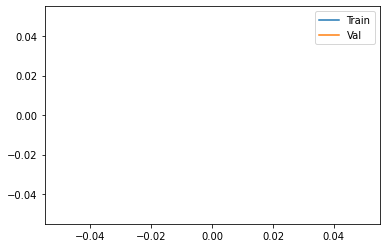

In [14]:
import matplotlib.pyplot as plt 

plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Val')
plt.legend()
plt.show()

In [10]:
labelfiles

['../data/processed/labels/primary_bhaduri_labels.csv',
 '../data/processed/labels/allen_cortex_labels.csv',
 '../data/processed/labels/allen_m1_region_labels.csv',
 '../data/processed/labels/whole_brain_bhaduri_labels.csv']

In [12]:
from numpy import memmap

In [15]:
f = memmap('../data/interim/allen_cortex_T.csv', dtype=np.float64, mode='r')

ValueError: Size of available data is not a multiple of the data-type size.